In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import gdown

url = "https://drive.google.com/uc?id=16FK1YnHPhGqCHf_EpovzcH0v90yXcCer"

output = 'artDL.zip'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=16FK1YnHPhGqCHf_EpovzcH0v90yXcCer
To: /content/artDL.zip
100%|██████████| 3.62G/3.62G [00:37<00:00, 96.6MB/s]


'artDL.zip'

In [ ]:
!unzip -q /content/artDL.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.nn.functional as F
import torchvision.transforms.functional as FT 

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [ ]:
info_df = pd.read_csv('/content/DEVKitArt/info.csv')

In [ ]:
train_set, test_set, val_set = info_df[info_df['set'] == 'train'], info_df[info_df['set'] == 'val'], info_df[info_df['set'] == 'test']

In [ ]:
import os
import cv2
import torch
from PIL import Image
class ArtDLDataset(Dataset):
  def __init__(self, data_dir = None, transform = None, labels_path = None, set_type = 'train'):

    # Setting the inital_dir to take images from
    self.data_dir = data_dir

    # Setting up the transforms
    self.transform = transform

    # Label path to reads labels_csv from
    self.labels_path = labels_path
    labels_df = pd.read_csv(self.labels_path)

    # Filtering df based on set type
    self.labels_df = labels_df[labels_df['set'] == set_type]
    self.img_names = list(self.labels_df['item'])

  def __getitem__(self, idx):

    # Getting the filename based on idx
    filename = self.img_names[idx]
    #print(filename)

    # Reading using PIL
    image = Image.open(self.data_dir + "/" + filename + ".jpg")

    # Applying transforms if any
    if(self.transform!=None):
      image = self.transform(image)
    
    # Getting the label 
    image_label = self.labels_df[self.labels_df['item'] == filename].values.squeeze()[2:20].argmax()
    #print(image_label)
    
    return (image, image_label)

  def __len__(self):
    return len(self.img_names)

classes = ["MARY",
"ANTONY ABBOT" ,
"ANTONY OF PADUA",
"AUGUSTINE",
"DOMINIC",
"FRANCIS",
"JEROME",
"JOHN THE BAPTIST",
"JOHN",
"JOSEPH",
"PAUL",
"PETER",
"SEBASTIAN",
"STEPHEN",
"BARBARA",
"CATHERINE",
"MARY MAGDALENE",
"John Baptist - Child",
"John Baptist - Dead"
]

In [ ]:
import torchvision.transforms as transforms
# Util class to apply padding to all the images
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return FT.pad(image, padding, 0, 'constant')

# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),

    transforms.Resize((224,224)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(p=0.5)
])


val_transform = transforms.Compose([
	  SquarePad(),
		transforms.Resize(224),
	  transforms.CenterCrop(224),
		transforms.ToTensor()
		
])

In [ ]:
train_dataset = ArtDLDataset(
    data_dir = '/content/DEVKitArt/JPEGImages',
    transform = transform,
    labels_path = '/content/DEVKitArt/info.csv',
    set_type = 'train'
)

test_dataset = ArtDLDataset(
    data_dir = '/content/DEVKitArt/JPEGImages',
    transform = val_transform,
    labels_path = '/content/DEVKitArt/info.csv',
    set_type = 'test'
)

val_dataset = ArtDLDataset(
    data_dir = '/content/DEVKitArt/JPEGImages',
    transform = val_transform,
    labels_path = '/content/DEVKitArt/info.csv',
    set_type = 'val'
)

In [ ]:
train_loader = DataLoader(dataset = train_dataset, shuffle=True, batch_size = 50)
test_loader = DataLoader(dataset = test_dataset, batch_size = 1)
val_loader = DataLoader(dataset = val_dataset, batch_size = 10)

In [ ]:
class ArtDLClassifier(nn.Module):
  def __init__(self, num_classes):
    super(ArtDLClassifier, self).__init__()
    # Loading the pretrained model
    self.resnet = models.resnet50(pretrained=True)

    self.stage1 = nn.Sequential(self.resnet.conv1, self.resnet.bn1, self.resnet.relu, self.resnet.maxpool,
                                    self.resnet.layer1)
    self.stage2 = nn.Sequential(self.resnet.layer2)
    self.stage3 = nn.Sequential(self.resnet.layer3)
    self.stage4 = nn.Sequential(self.resnet.layer4)

    self.avgpool = self.resnet.avgpool
    self.fc_conv = nn.Conv2d(in_channels = 2048, out_channels = num_classes, kernel_size=1)

    # Setting the trainable params for the optimizer
    self.tr_params = nn.ModuleList([self.stage1, self.stage2, self.stage3, self.stage4, self.avgpool, self.fc_conv])

    self.gradients = None
   #hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad

  def forward(self, image):
    # Forward prop
    out = self.stage1(image)
    out = self.stage2(out)
    out = self.stage3(out)
    h = out.register_hook(self.activations_hook)
    out = self.stage4(out)

    # h = out.register_hook(self.activations_hook) #####

    out = self.avgpool(out)
    
    out = self.fc_conv(out)
    return out

  def trainable_params(self):
    return (list(self.tr_params.parameters()))

  def get_activations_gradient(self):
        return self.gradients
    
  # method for the activation extraction
  def get_activations(self, x):
    out = self.stage1(x)
    out = self.stage2(out)
    # out = self.stage3(out)
    return self.stage3(out)
    
    # return self.stage4(out)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
clf = ArtDLClassifier(num_classes = 19).to(device)
optimizer = optim.SGD(clf.trainable_params(), lr = 0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
clf.load_state_dict(torch.load("/content/gdrive/MyDrive/ArtDl_Models/artDLresnet50_224x224_4.pt", map_location = device))

<All keys matched successfully>

In [ ]:
def get_gradcam(model, image, label, size):
  label.backward(retain_graph=True)
  gradients = model.get_activations_gradient()
  pooled_gradients = torch.mean(gradients, dim=[0,2,3])
  activations = model.get_activations(image).detach()

  for i in range(activations.shape[1]):
    activations[:,i,:,:]*=pooled_gradients[i]
  heatmap=torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = np.maximum(heatmap, 0)


  heatmap /= torch.max(heatmap)

  heatmap_exp = cv2.resize(heatmap.numpy(), (size, size))
  return heatmap_exp, heatmap.numpy()

In [ ]:
def plot_heatmap(denorm_image, actual, displaying, heatmap):

    fig, (ax1, ax2) = plt.subplots(figsize=(20,20), ncols=2)


    fig.suptitle(f'Predicted class - {classes[actual]}, Displaying class - {classes[displaying]}')
    fig.tight_layout()
    ps = torch.nn.Softmax(dim = 1)(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)



    ax2.imshow(denorm_image)
    ax2.imshow(heatmap, cmap='magma', alpha=0.7)


In [ ]:
image, label = val_dataset[0]
denorm_image = image.permute(1, 2, 0)
print(classes[label])
image = image.unsqueeze(0).to(device)

pred = clf(image)

MARY


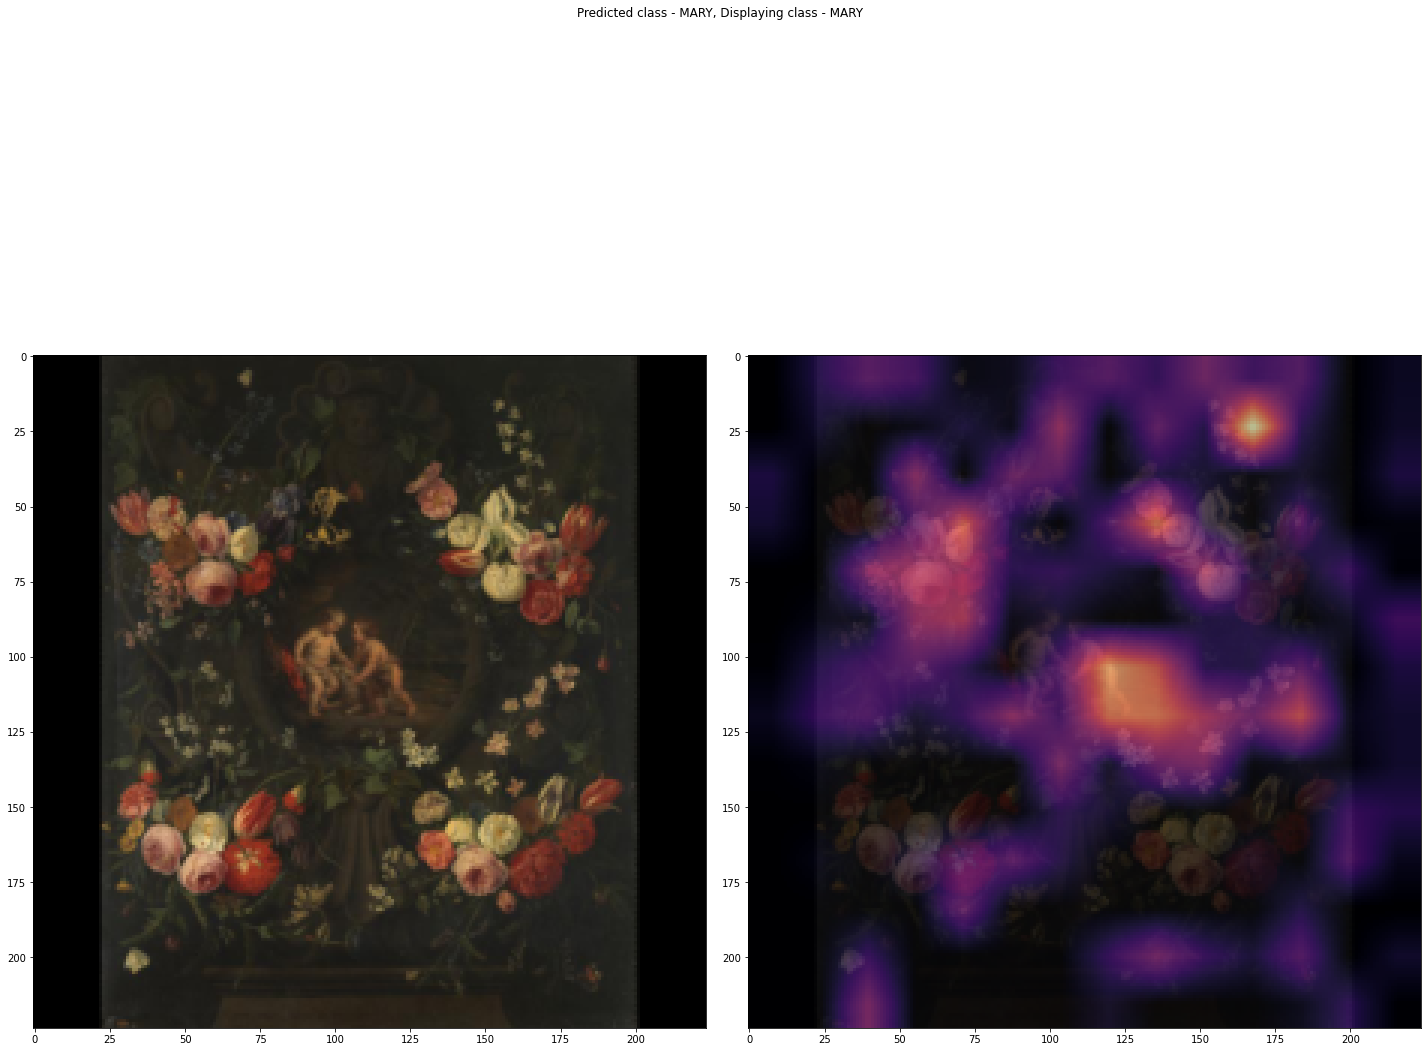

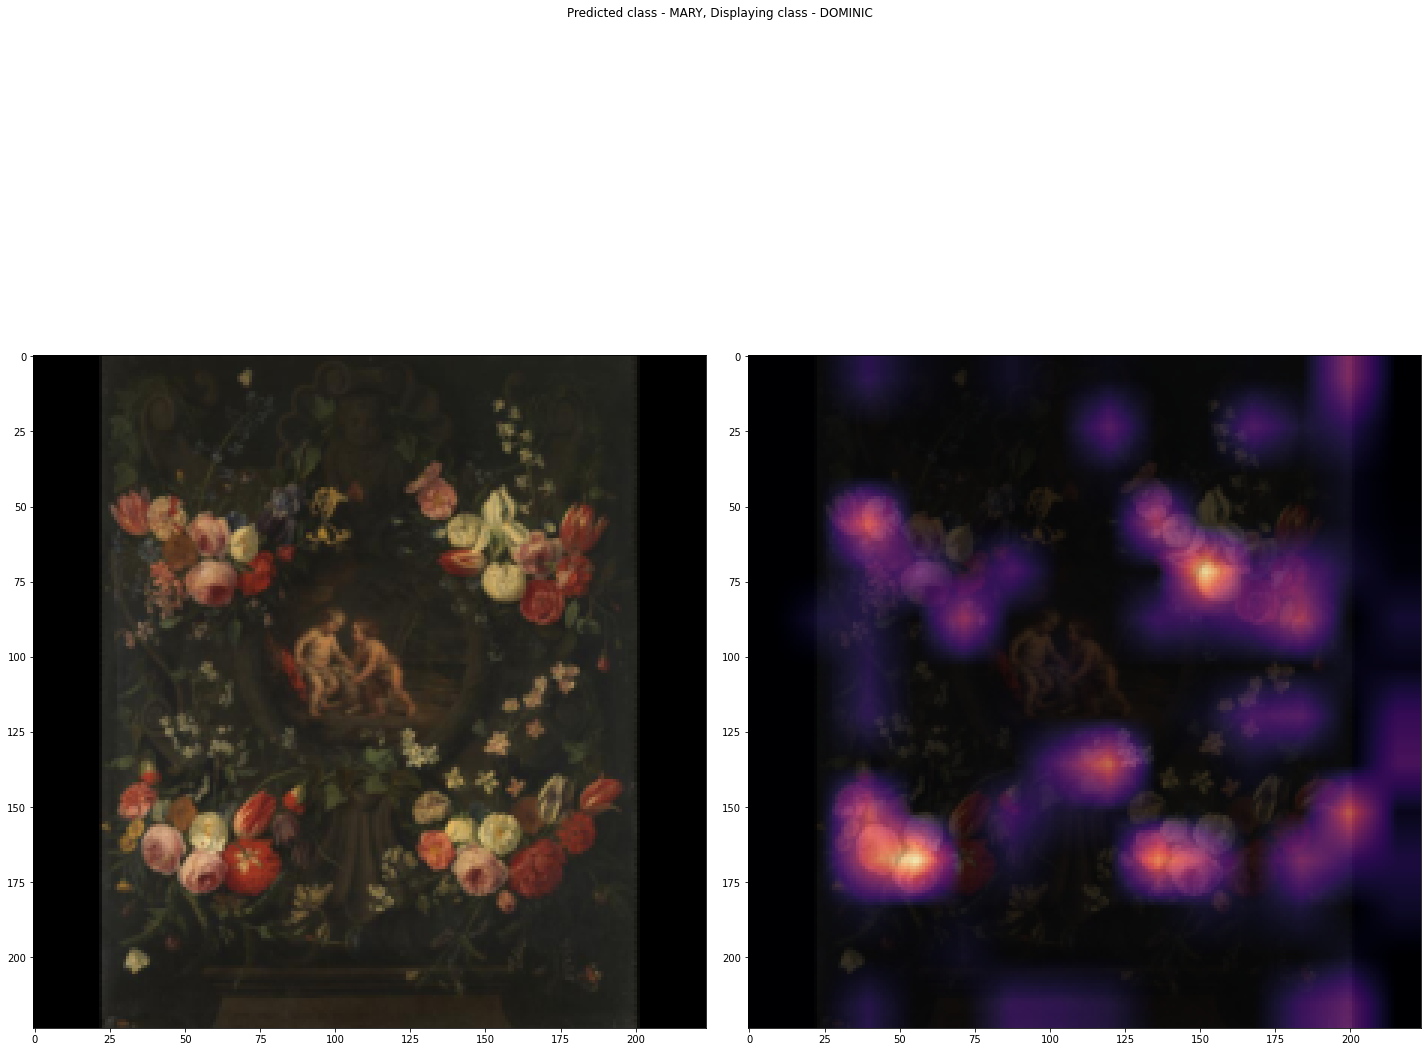

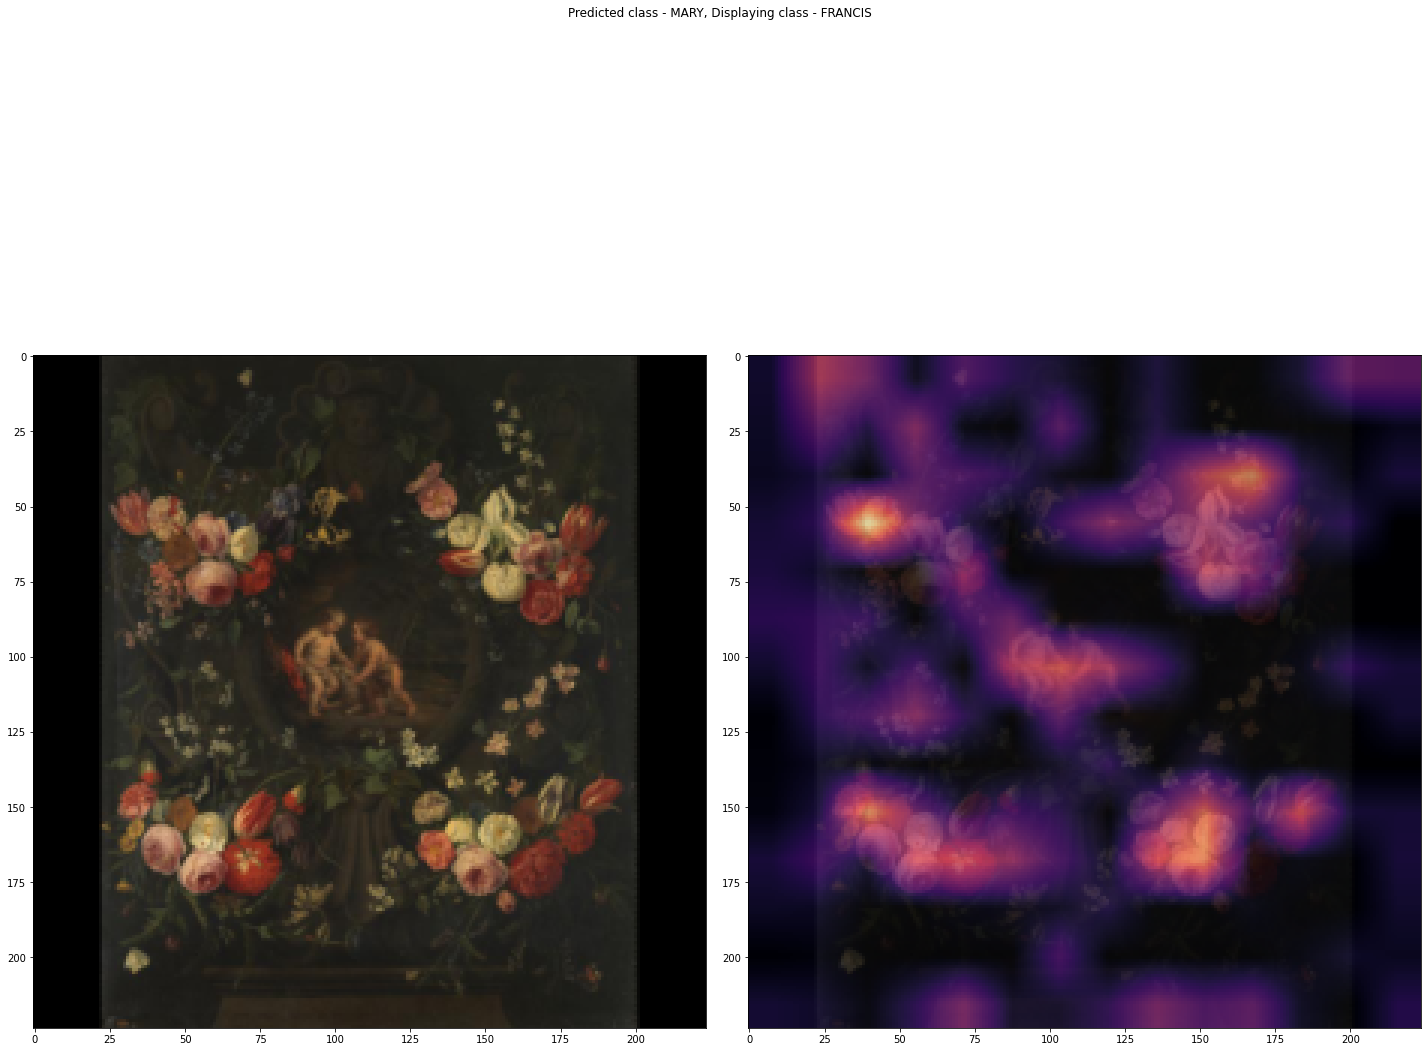

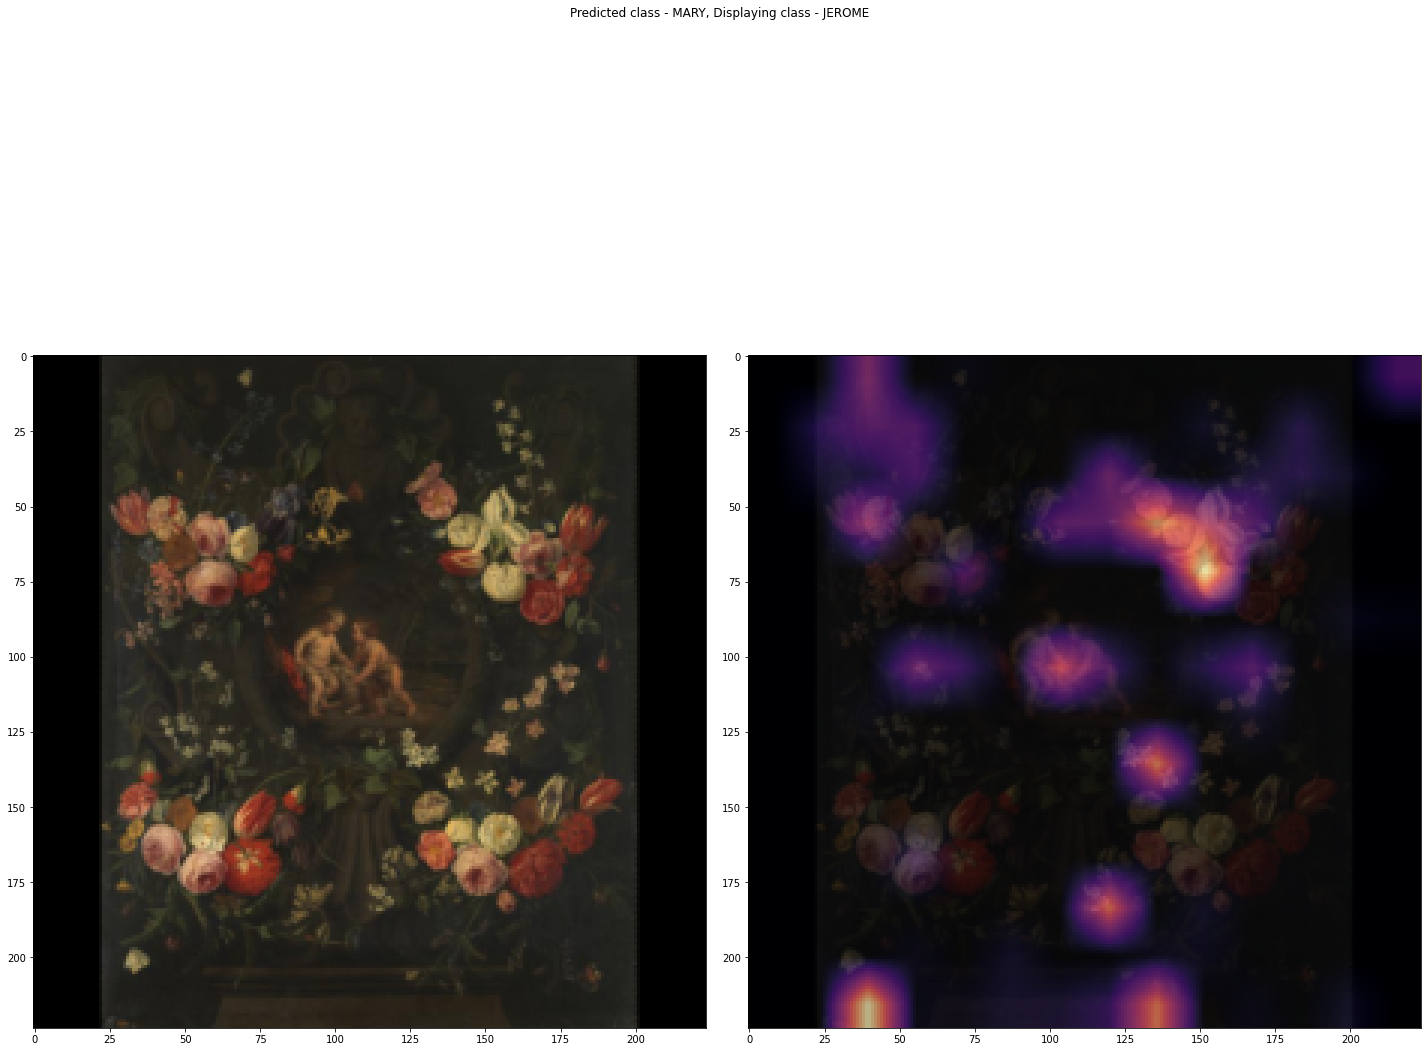

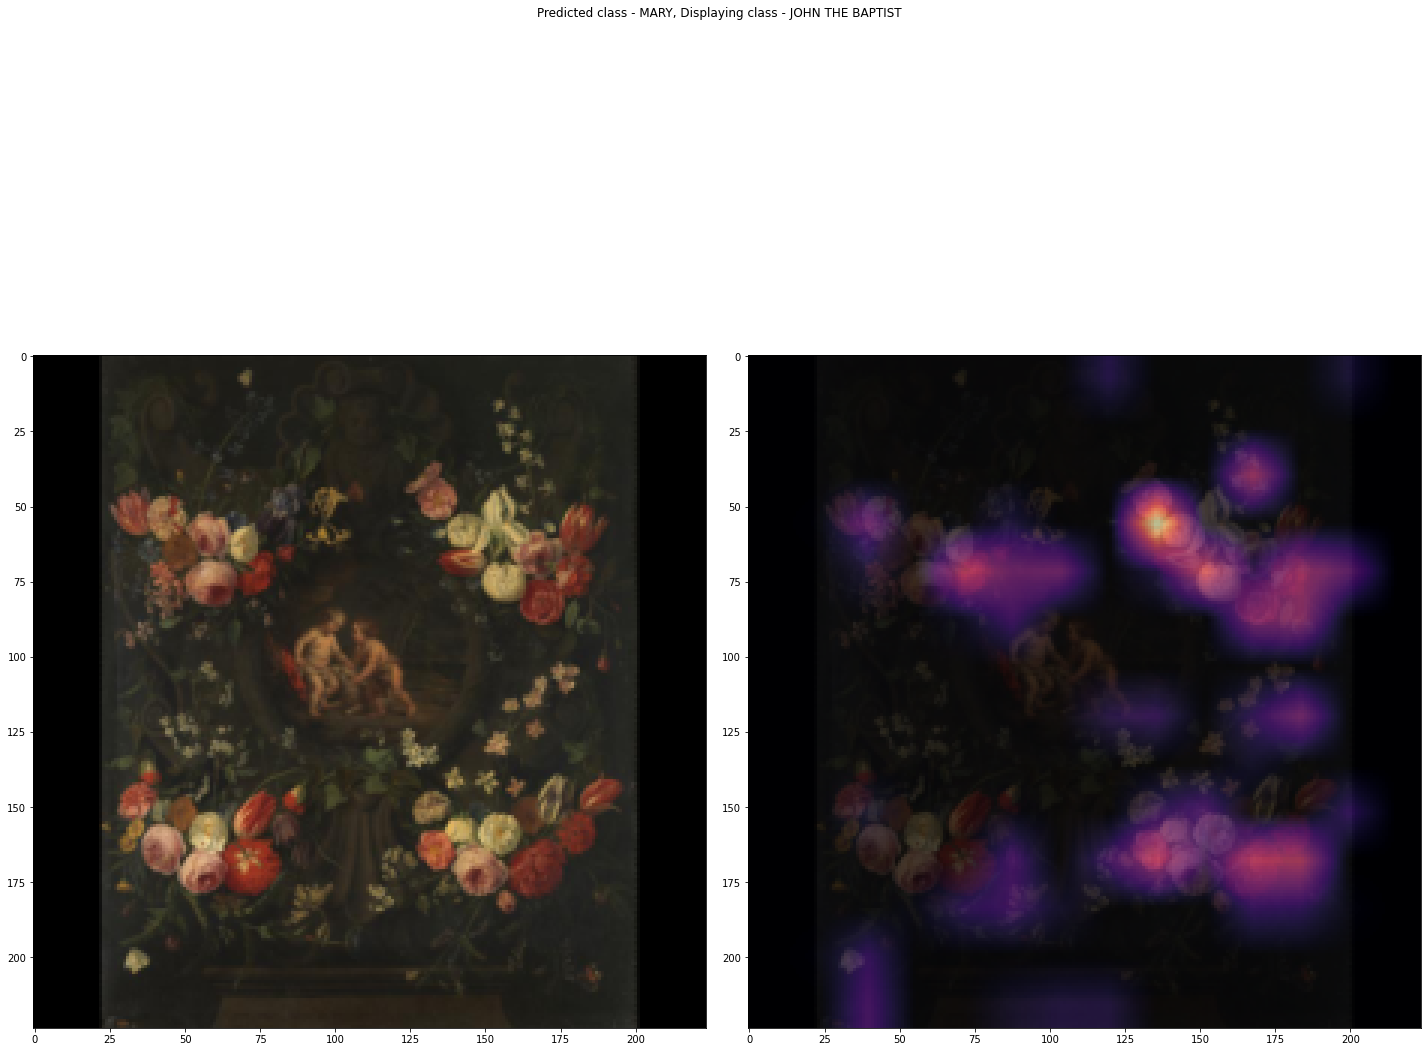

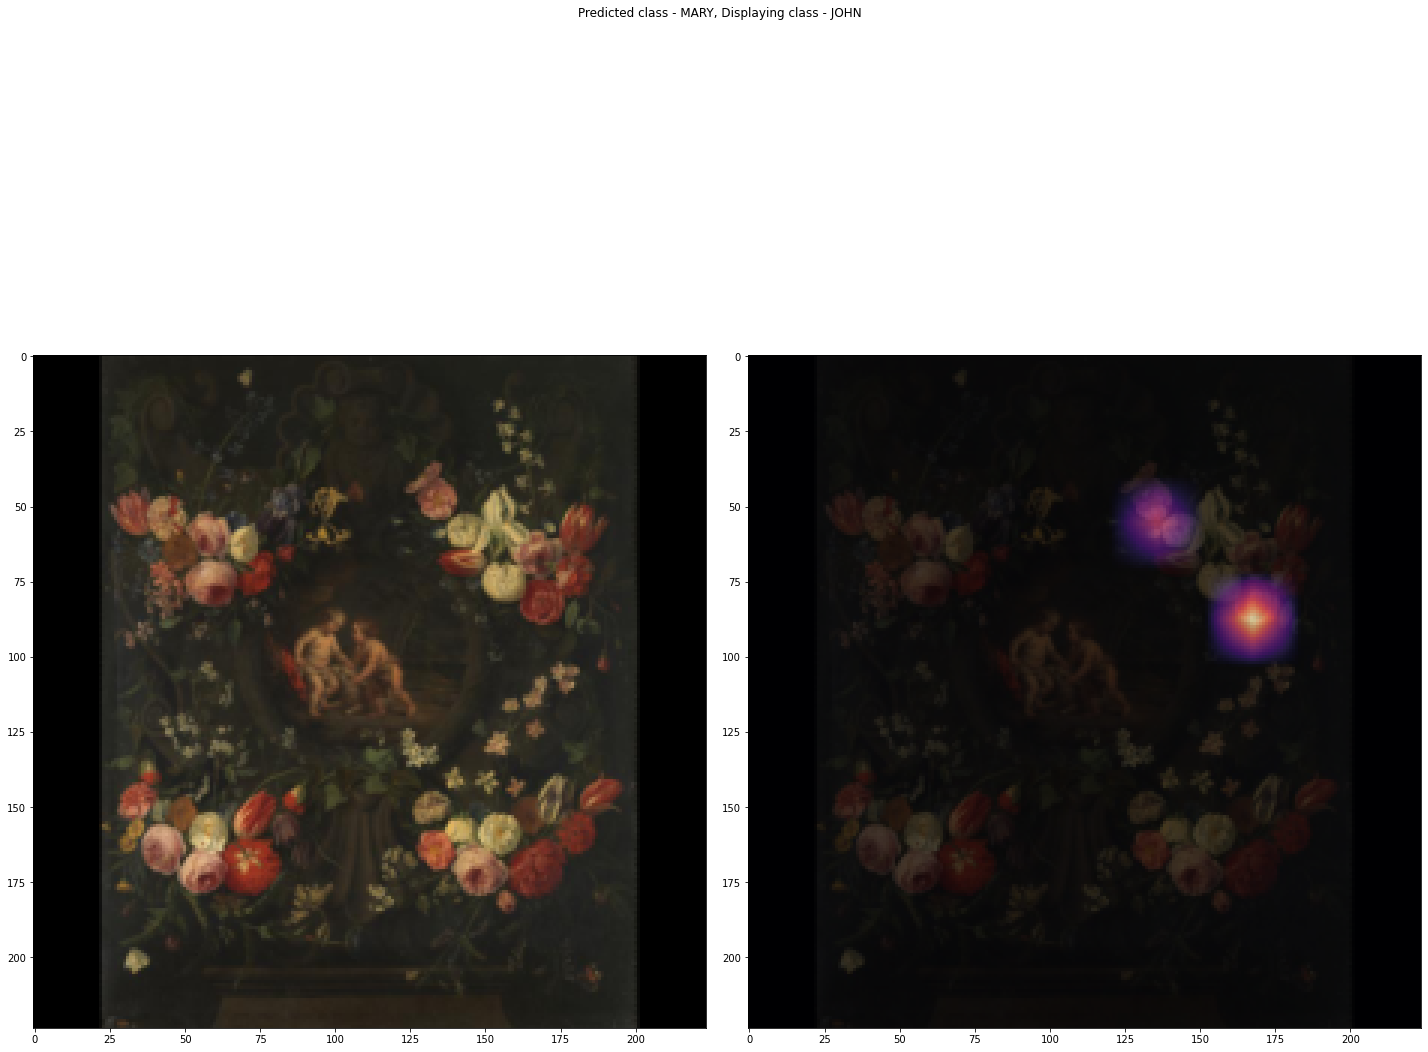

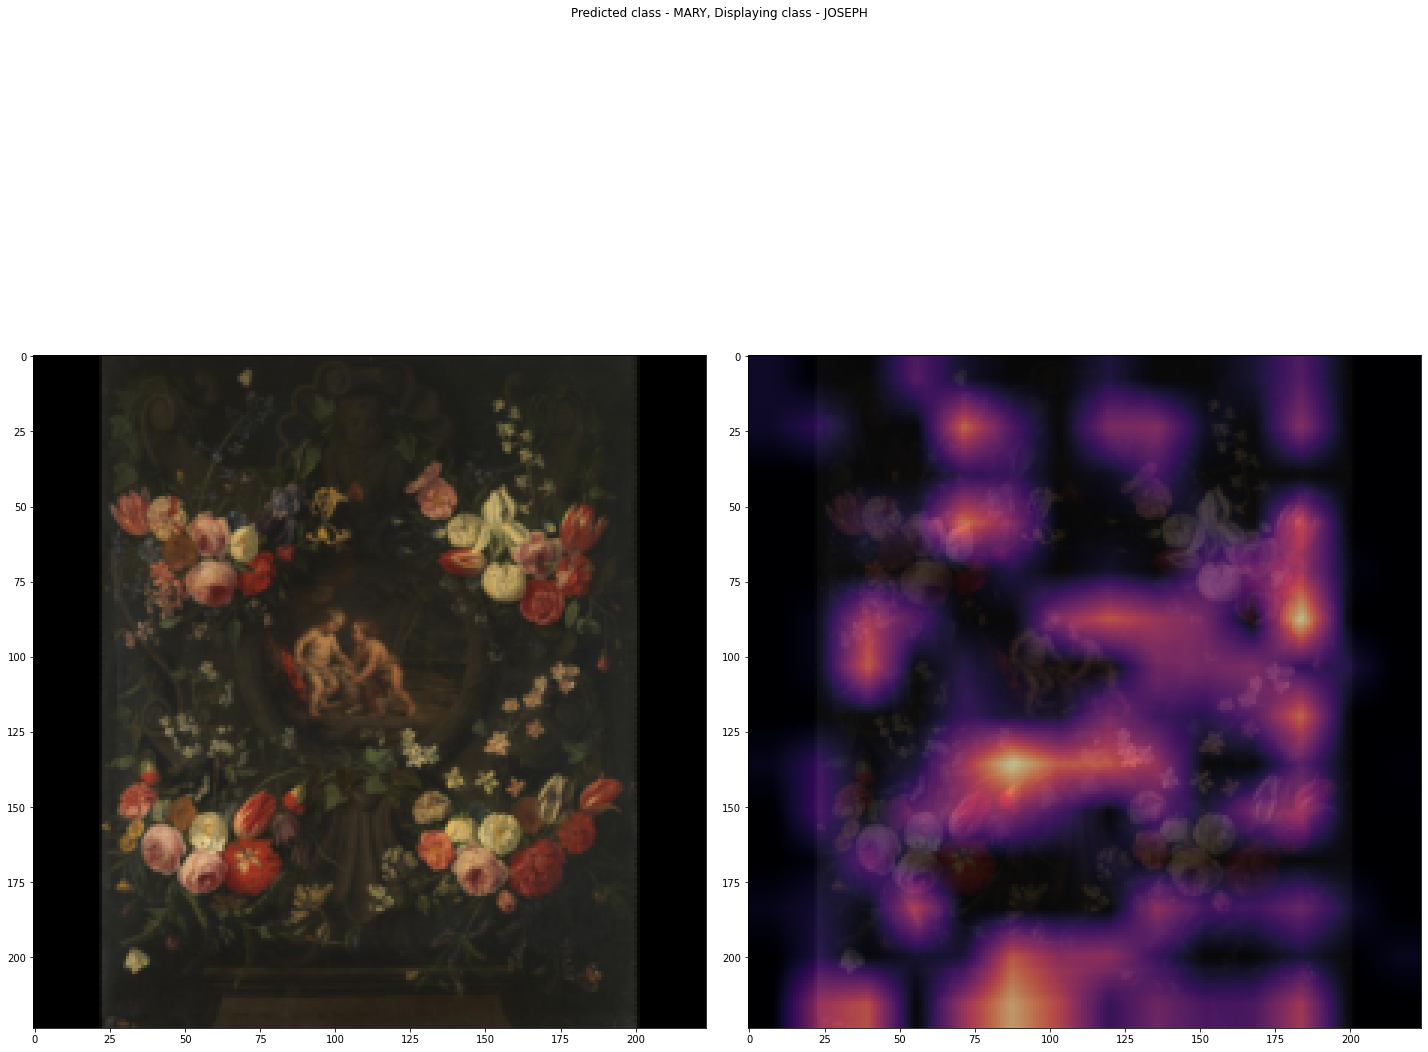

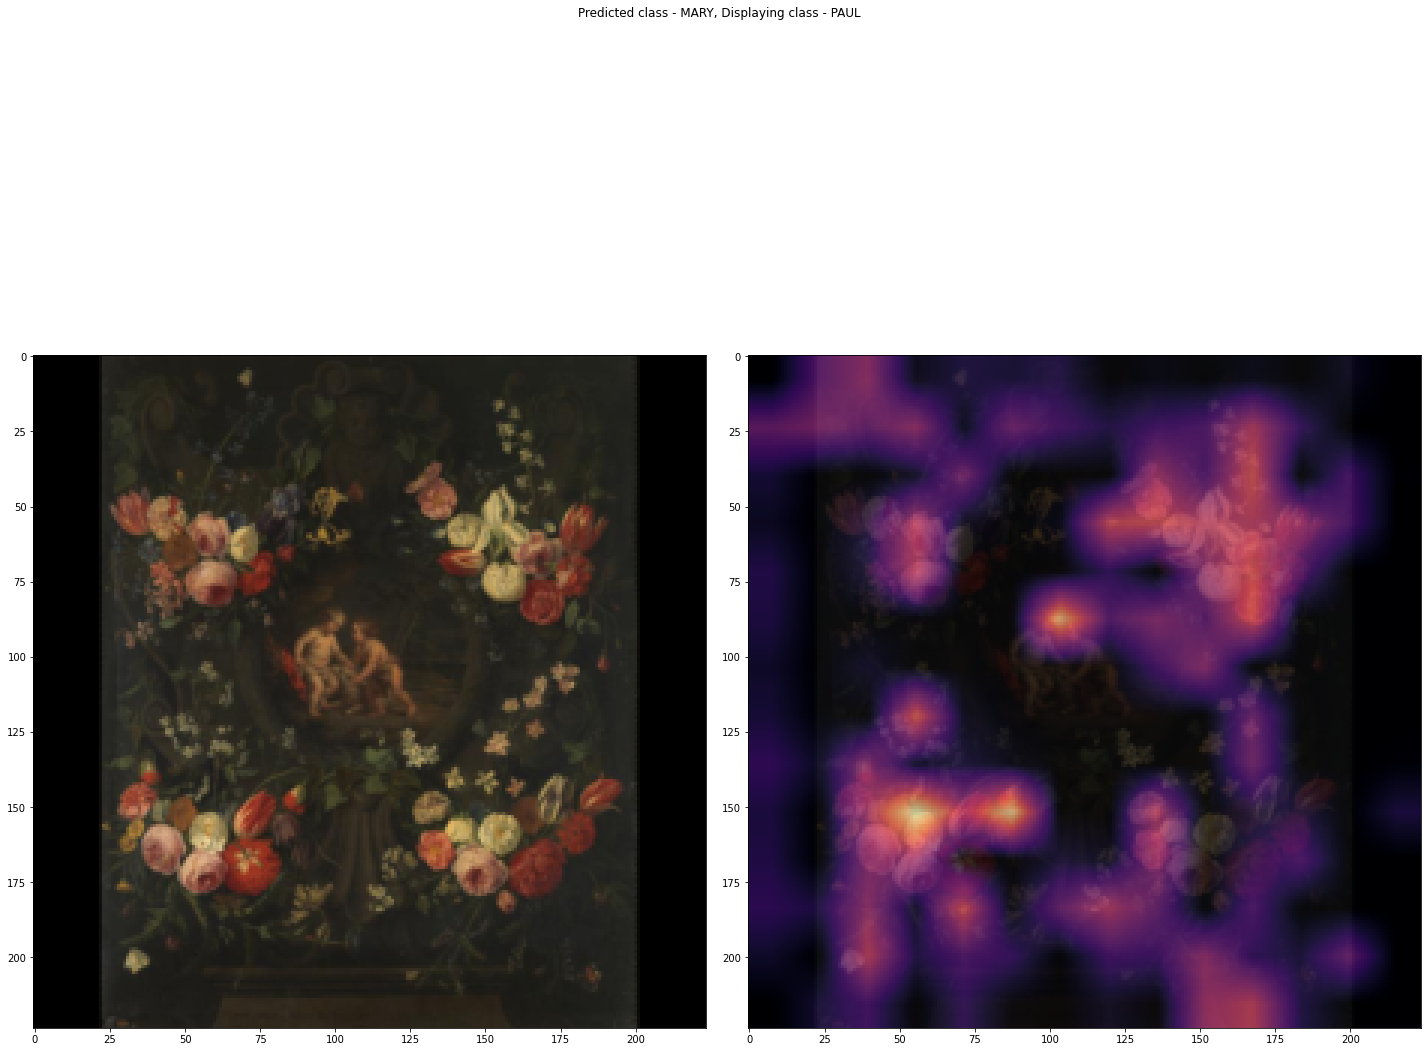

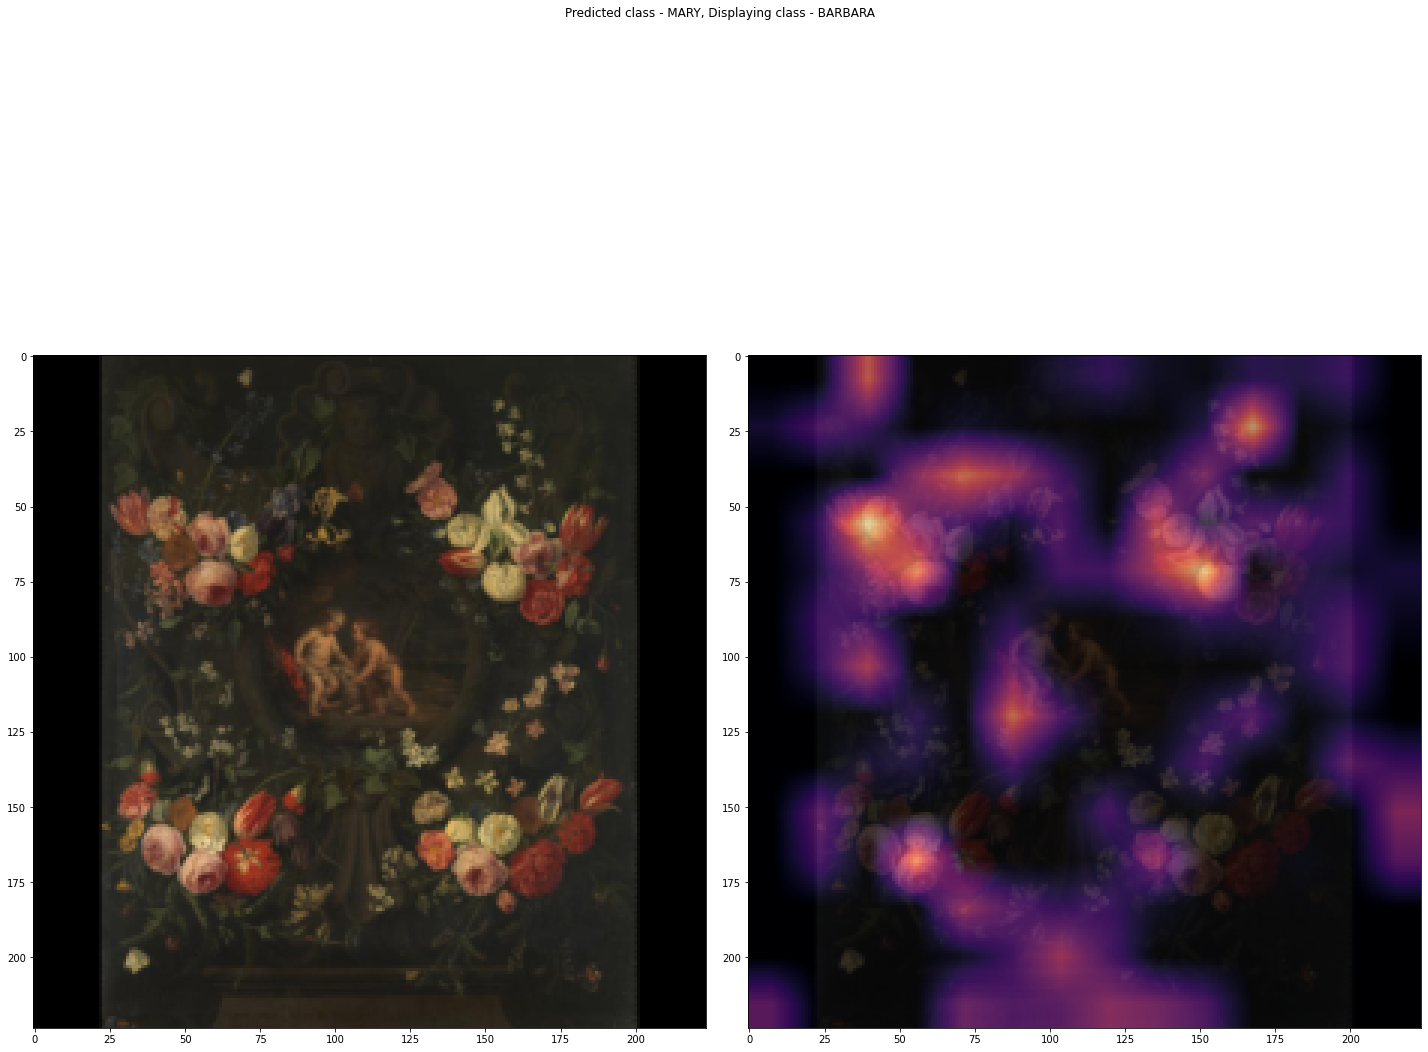

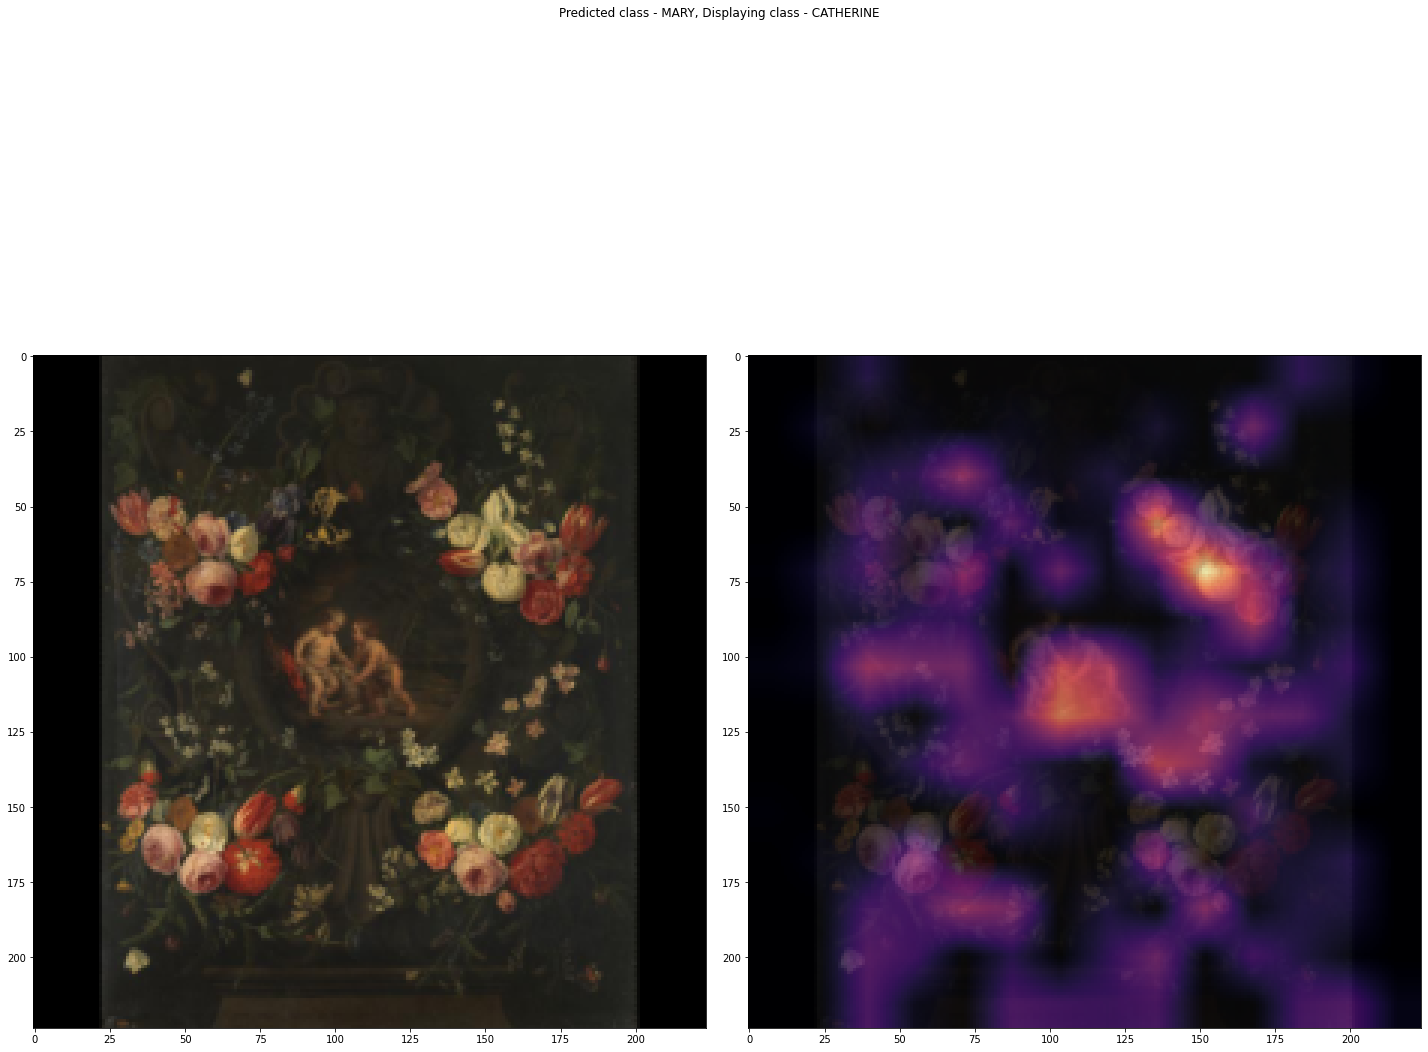

In [ ]:
p = pred[0]
actual = pred.argmax().cpu().detach().numpy()
for i in range(len(p)):
  if p[i] > 0:
    # print(p[i])
    heatmap, sm_heatmap = get_gradcam(clf, image, p[i], size=224)

    plot_heatmap(denorm_image, pred.argmax().cpu().detach().numpy(), i, heatmap)


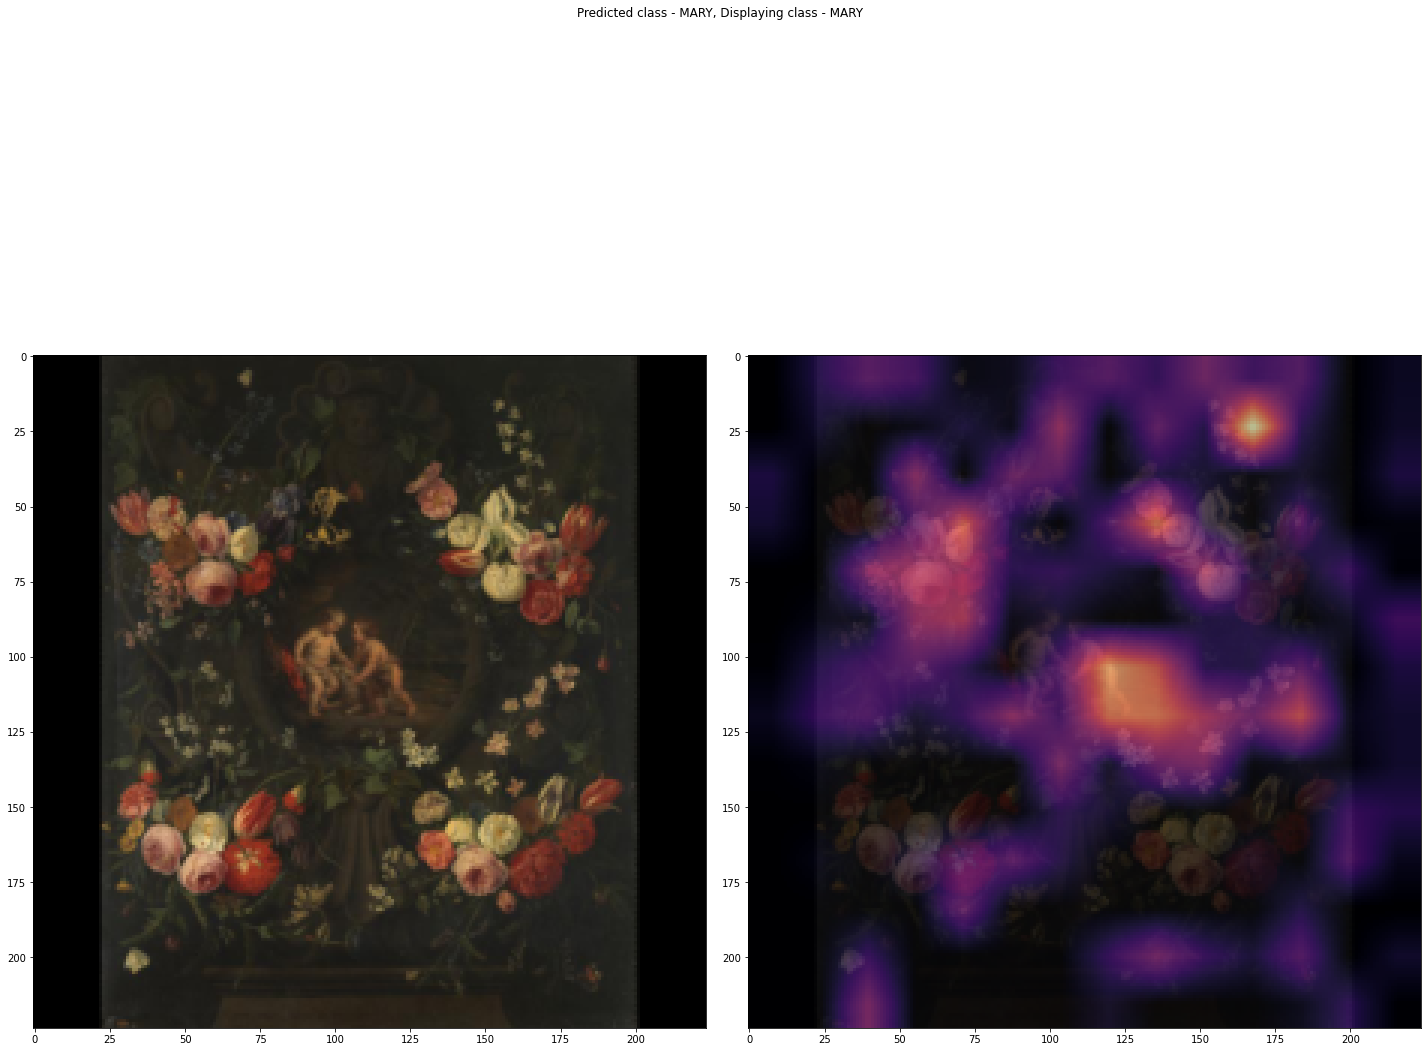

In [ ]:
pred = clf(image)
heatmap, sm_heatmap = get_gradcam(clf, image, pred[0][0], size=224)

plot_heatmap(denorm_image, pred.argmax().cpu().detach().numpy(), 0, heatmap)

In [ ]:
pred

tensor([[[[ 9.0980]],

         [[-3.4574]],

         [[-2.2010]],

         [[-0.8751]],

         [[ 2.2071]],

         [[ 1.0835]],

         [[ 2.1010]],

         [[ 1.1708]],

         [[ 3.3015]],

         [[ 0.8088]],

         [[ 1.8284]],

         [[-0.0901]],

         [[-2.3900]],

         [[-1.9207]],

         [[ 0.5151]],

         [[ 2.2199]],

         [[-2.1343]],

         [[-2.3752]],

         [[-9.8519]]]], grad_fn=<ConvolutionBackward0>)

In [ ]:
sm_heatmap.mean()

0.14617619

In [ ]:
# Regions:
def dfs(grid, r, c, color, size, threshold):

  rowNbr = [0, 0, 1, -1]
  colNbr = [1, -1, 0, 0]

  grid[r][c] = color
  for i in range(4):
    tr = r+rowNbr[i]
    tc = c+colNbr[i]

    if(tr<0 or tr>=size or tc < 0 or tc >= size or grid[tr][tc] < threshold or grid[tr][tc] > 1):
      continue
    grid = dfs(grid, tr, tc, color, size, threshold)

  return grid
def roi(sm_heatmap, size):
  regions = []

  rowNbr = [0, 0, 1, -1]
  colNbr = [1, -1, 0, 0]

  color = 2
  color_map = {}
  threshold = sm_heatmap.mean()
  for i in range(size):
    for j in range(size):
      if(sm_heatmap[i][j] > 0.2 and sm_heatmap[i][j] < 2):
        sm_heatmap = dfs(sm_heatmap, i, j, color, size, threshold)
        color_map[color] = [i, j]
        color+=1
  
  sm_heatmap = sm_heatmap.astype(int)

  for i in range(2, color):
    start = color_map[i]

    cells = []
    cells.append(start)

    for j in range(4):
      tx = start[0]+rowNbr[j]
      ty = start[1]+colNbr[j] 

      if(tx<0 or tx>=size or ty < 0 or ty >= size):
        continue
      if(sm_heatmap[tx][ty] == i):
        cells.append([tx, ty])
    
    # top left and bottom right

    ml, mr, mt, mb = 14,-1,14,-1
    for c in cells:
      if(c[0] < ml): ml = c[0]
      if(c[0] > mr): mr = c[0]
      if(c[1] < mt): mt = c[1]
      if(c[1] > mb): mb = c[1]

    regions.append([[ml, mt], [mr, mb]])

  # Convert them to pixel coordinates
  for r in regions:
    r[0] = [x*16 for x in r[0]]
    r[1] = [(x+1)*16-1 for x in r[1]]
  # print(regions)
  return regions

In [ ]:
regions = roi(sm_heatmap, 14)

In [ ]:
regions

[[[0, 16], [15, 63]],
 [[0, 96], [31, 127]],
 [[48, 112], [63, 143]],
 [[48, 176], [63, 191]],
 [[64, 144], [79, 159]],
 [[64, 192], [79, 207]],
 [[80, 208], [111, 223]],
 [[144, 192], [175, 223]],
 [[192, 32], [223, 47]],
 [[192, 112], [207, 143]],
 [[192, 176], [207, 191]]]

In [ ]:
obj = image[0:1, 0:3, regions[7][0][0]:regions[7][1][0], regions[7][0][1]:regions[7][1][1]]

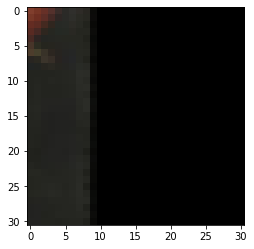

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(obj[0].permute(1,2,0).numpy())

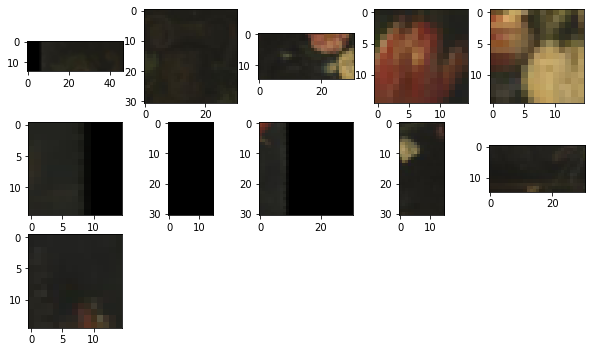

In [ ]:
fig = plt.figure(figsize= (10, 10))

for i in range(len(regions)):
  r = regions[i]
  obj = image[0:1, 0:3, r[0][0]:r[1][0], r[0][1]:r[1][1]]
  ax = fig.add_subplot(5, 5, i+1)
  ax.imshow(obj[0].permute(1, 2, 0).numpy())
